In [93]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [94]:
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from typing import TypedDict
from langchain_postgres.vectorstores import PGVector
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document


In [95]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [96]:
# import config
import os 
os.chdir("D:/Projects/Nutrition-Agent")
from config import Config

cfg = Config()

In [97]:
from sqlalchemy import create_engine
engine = create_engine(cfg.get_postgres_uri(), pool_pre_ping=True)

In [98]:
class RAGState(TypedDict):
    query: str
    docs: list
    answer: str
    new_docs: list

In [99]:
collection_name = "langchain_pg_collection"

vector_store = PGVector(
    embeddings=embeddings,
    collection_name=collection_name,
    connection=engine,
    use_jsonb=True,
)

In [100]:
def retrive_document(state: RAGState):
    
    query = state['query']

    docs = vector_store.similarity_search(query, k=3)

    state['docs'] = docs
    
    return {"docs": docs}

In [101]:
def store_documents(state: RAGState):

    new_docs = state['new_docs']

    if not new_docs:
        return {}
    
    unique_docs = []
    for doc in new_docs:
        existing = vector_store.similarity_search(doc.page_content, k=1)
        if existing and existing[0].page_content == doc.page_content:
            print(f"Duplicate found, skipping: {doc.metadata.get('source', 'unknown')}")
        else:
            unique_docs.append(doc)


    if unique_docs:
        vector_store.add_documents(unique_docs)
        print(f"Stored {len(unique_docs)} new documents.")
    else:
        print("No unique documents to store.")


    return {}

In [102]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

def store_documents(state: RAGState):
    new_docs_paths = state.get("new_docs")

    if not new_docs_paths:
        print("No new documents provided.")
        return {}

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )

    unique_docs = []

    for file_path in new_docs_paths:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        chunks = text_splitter.split_text(content)
        docs = [Document(page_content=chunk, metadata={"source": file_path}) for chunk in chunks]

        for doc in docs:
            existing = vector_store.similarity_search(doc.page_content, k=1)
            if existing and existing[0].page_content == doc.page_content:
                print(f"Duplicate found, skipping: {file_path}")
            else:
                unique_docs.append(doc)

    if unique_docs:
        vector_store.add_documents(unique_docs)
        print(f"Stored {len(unique_docs)} new document chunks.")
    else:
        print("No unique documents to store.")

    return {}


In [103]:
import os
base_dir = os.getcwd()
prompt_path = os.path.join(base_dir, "experiment", "prompt.txt")
prompt_path

'D:\\Projects\\Nutrition-Agent\\experiment\\prompt.txt'

In [104]:
from langchain_core.prompts import PromptTemplate

def generate_answer(state: RAGState) -> dict:
    query = state["query"]
    docs = state.get("docs", [])
    
    if docs:
        context = "\n\n".join([f"Source: {doc.metadata.get('source', 'Unknown')}\n{doc.page_content}" for doc in docs])
    else:
        context = "No relevant documents found."
    
    base_dir = os.getcwd()
    prompt_path = os.path.join(base_dir, "experiment", "prompt.txt")
    
    with open(prompt_path, 'r', encoding="utf-8") as f:
        template_text = f.read() 

    prompt_template = PromptTemplate(
        template=template_text,
        input_variables=["query", "context"]
    )

    chain = prompt_template | llm

    response = chain.invoke({"query": query, "context": context})

    return {**state, "answer": response.content}


In [105]:
def check_new_node(state: RAGState):
    return "store" if state['new_docs'] else "fetch"

In [106]:
graph = StateGraph(RAGState)

# add nodes 
graph.add_node("retrive_documents", retrive_document)
graph.add_node("store_documents", store_documents)
graph.add_node("generate_answer", generate_answer)

# add edges 
graph.add_conditional_edges(
    START,
    check_new_node,
    {
        "store": "store_documents",
        "fetch": "retrive_documents"
    }
)
# After the conditional edges, connect the remaining nodes
graph.add_edge("store_documents", "retrive_documents")
graph.add_edge("retrive_documents", "generate_answer")
graph.add_edge("generate_answer", END)



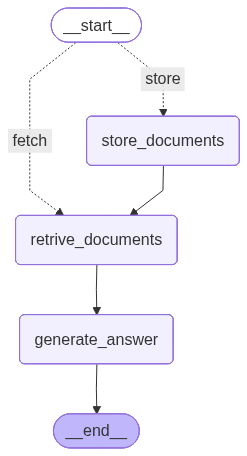

In [107]:
workflow = graph.compile()
workflow

In [108]:
# ! uv pip install --upgrade langchain langsmith?


In [109]:
from langchain.globals import set_debug
import os

# Enable LangSmith tracing
set_debug(True)


In [110]:
initial_state: RAGState = {
    "query": "What do you think maharashtra breakfast is the envirnmentally good?",
    "docs": [],
    "answer": "",
    "new_docs": [] 
}


In [111]:
# final_state = workflow.invoke(initial_state)  # Automatically logged to LangSmith


In [112]:
from config import Config
import os

# Load configuration
cfg = Config()

# Access LangSmith values like a dict
ls_api_key = cfg.config['langsmith']['api_key']
ls_project = cfg.config['langsmith']['project']
ls_tracing = cfg.config['langsmith']['tracing']
ls_endpoint = cfg.config['langsmith']['endpoint']


In [83]:
final_state = workflow.invoke(initial_state)
print(final_state.get("answer"))

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:check_new_node] Entering Chain run with input:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/end] [chain:LangGraph > chain:__start__ > chain:check_new_node] s] Exiting Chain run with output:
{
  "output": "fetch"
}
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/st

In [ ]:
from langsmith import Client

client = Client(api_key=ls_api_key)
final_state = workflow.invoke(initial_state)
print(final_state.get("answer"))

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:check_new_node] Entering Chain run with input:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/end] [chain:LangGraph > chain:__start__ > chain:check_new_node] s] Exiting Chain run with output:
{
  "output": "fetch"
}
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
{
  "query": "What do you think maharashtra breakfast is the envirnmentally good?",
  "docs": [],
  "answer": "",
  "new_docs": []
}
[chain/st

In [114]:
# Optional: Log this example to LangSmith dataset
dataset_name = ls_project
client.create_dataset(dataset_name)

client.create_example(
    inputs={"query": final_state.get("query")},
    outputs={"answer": final_state.get("answer")},
    dataset_name=dataset_name
)

<class 'langsmith.schemas.Example'>(id=65f1f114-4742-4d8b-bd86-12c57ab60bbc, dataset_id=254d3a88-de91-4b8a-a23a-d98ccd435667, link='https://smith.langchain.com/o/08ad5c57-a420-471a-95ef-9a1660a194f7/datasets/254d3a88-de91-4b8a-a23a-d98ccd435667/e/65f1f114-4742-4d8b-bd86-12c57ab60bbc')

In [ ]:
from langsmith import Client

client = Client(api_key=ls_api_key)
final_state = workflow.invoke(initial_state)
print(final_state.get("answer"))

In [125]:
initial_state: RAGState = {
    "query": "Is Maharashtra dinner protein rich? What foods are included?",
    "docs": [],
    "answer": "",
    "new_docs": []
}



cfg = Config()


client = Client()

final_state = workflow.invoke(initial_state)
print(final_state.get("answer"))


RuntimeError: Tracing using LangChainTracerV1 is no longer supported. Please set the LANGCHAIN_TRACING_V2 environment variable to enable tracing instead.